✓ XGBoost available
✓ Statsmodels available
Library status: XGBoost=True, Statsmodels=True
Starting analysis with file path:
F:/Data Science/Data Set/SYB67_1_202411_Population, Surface Area and Density.csv

Make sure your file is at this exact location!
If the file is elsewhere, update the FILE_PATH variable at the top of this code.
=== POPULATION FORECASTING & PREDICTIVE MODELING ===
Loading and cleaning data...
Attempting to load file: F:/Data Science/Data Set/SYB67_1_202411_Population, Surface Area and Density.csv
File loaded successfully with UTF-8 encoding
Original data shape: (7711, 7)
Original columns: ['T02', 'Population, density and surface area', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
Detected header row, skipping...
Data shape after skipping header: (7710, 7)
New column names: ['region_code', 'country_name', 'year', 'indicator', 'value', 'notes', 'data_source']
Filtered out aggregates: 7710 -> 7681 rows
Final cleaned data shape: (7681, 7)
Count

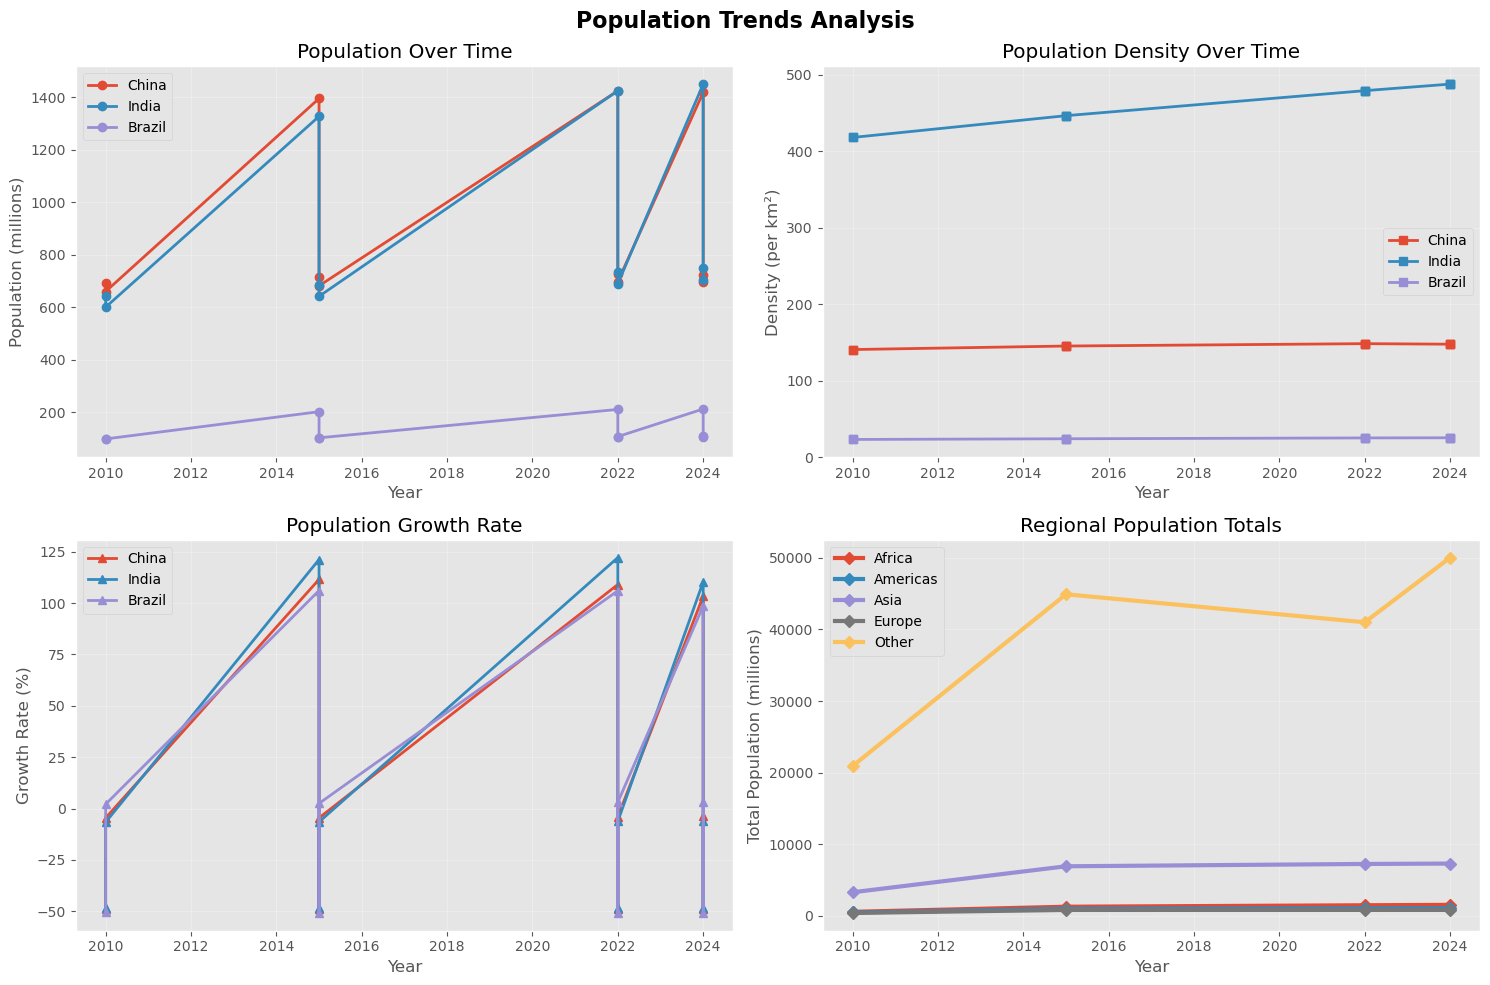

Showing forecast for: China


C:\Users\kaust\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kaust\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


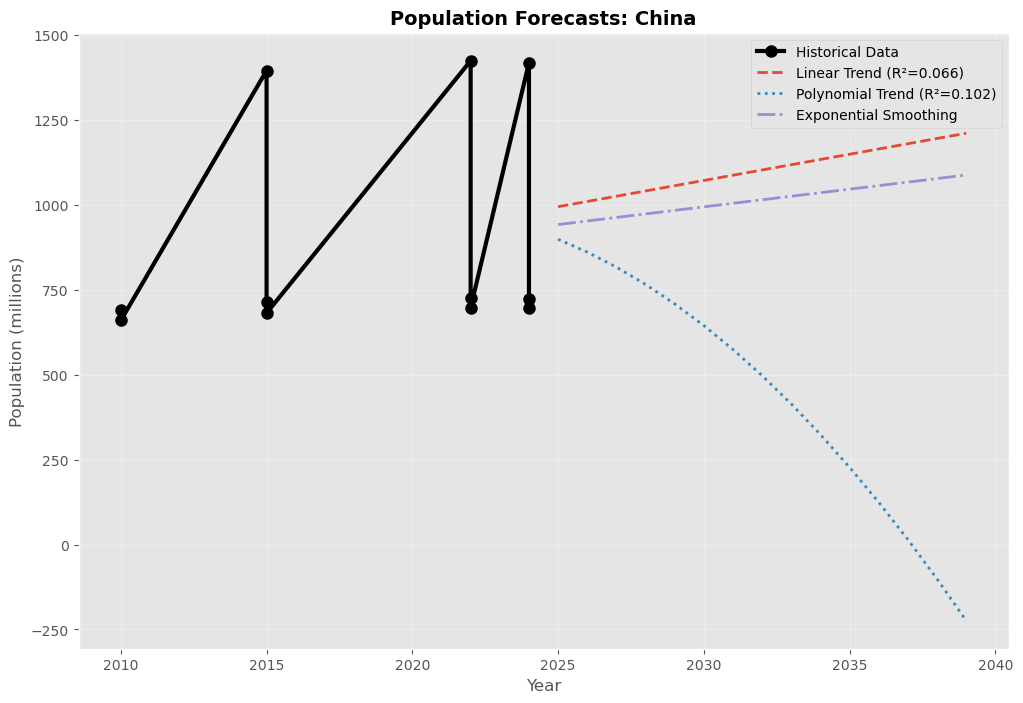


=== ANALYSIS COMPLETE! ===
Your results are stored in the 'results' variable
Available data: ['data', 'raw_data', 'rf_model', 'xgb_model', 'countries']


In [1]:
# Install required packages first
!pip install xgboost
!pip install statsmodels

# Population Trends Analysis & Forecasting
# Building ML models to predict demographic changes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
import warnings
import os
import datetime

warnings.filterwarnings('ignore')

# Try to import optional libraries and set flags
try:
    import xgboost as xgb
    HAS_XGBOOST = True
    print("✓ XGBoost available")
except ImportError:
    HAS_XGBOOST = False
    print("✗ XGBoost not available - will use Gradient Boosting instead")

try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tsa.arima.model import ARIMA
    HAS_STATSMODELS = True
    print("✓ Statsmodels available")
except ImportError:
    HAS_STATSMODELS = False
    print("✗ Statsmodels not available - will use polynomial forecasting instead")

plt.style.use('ggplot')

# Set the file path for your data
FILE_PATH = r'F:/Data Science/Data Set/SYB67_1_202411_Population, Surface Area and Density.csv'

print(f"Library status: XGBoost={HAS_XGBOOST}, Statsmodels={HAS_STATSMODELS}")

def load_and_clean_data(file_path):
    """
    The UN data format is pretty messy, so we need to do some cleanup
    """
    print(f"Attempting to load file: {file_path}")
    
    # Check if file exists first
    if not os.path.exists(file_path):
        print(f"ERROR: File not found at {file_path}")
        print("Please check the file path and name")
        return None
    
    # Load the CSV - sometimes there's junk in the first few rows
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
        print("File loaded successfully with UTF-8 encoding")
    except:
        try:
            df = pd.read_csv(file_path, encoding='latin-1')
            print("File loaded successfully with Latin-1 encoding")
        except Exception as e:
            print(f"Error loading file: {e}")
            return None
    
    print(f"Original data shape: {df.shape}")
    print(f"Original columns: {list(df.columns)}")
    
    # Check if we need to skip header rows
    if 'T02' in str(df.columns[0]) or df.iloc[0, 0] == 'T02':
        print("Detected header row, skipping...")
        df = pd.read_csv(file_path, skiprows=1)
        print(f"Data shape after skipping header: {df.shape}")
    
    # Give the columns better names
    col_names = ['region_code', 'country_name', 'year', 'indicator', 'value', 'notes', 'data_source']
    if len(df.columns) >= len(col_names):
        df.columns = col_names[:len(df.columns)]
    else:
        df.columns = col_names[:len(df.columns)]
    
    print(f"New column names: {list(df.columns)}")
    
    # Clean up the values - remove commas and quotes
    if 'value' in df.columns:
        df['value'] = df['value'].astype(str).str.replace(',', '').str.replace('"', '')
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
    
    # Drop the aggregate stuff - we want individual countries
    if 'country_name' in df.columns:
        before_filter = len(df)
        df = df[~df['country_name'].str.contains('Total|World|More developed|Less developed', na=False)]
        print(f"Filtered out aggregates: {before_filter} -> {len(df)} rows")
    
    # Only keep rows with actual data
    df = df.dropna(subset=['value', 'year'])
    df = df[df['year'] > 1990]  # Focus on more recent data
    
    print(f"Final cleaned data shape: {df.shape}")
    print(f"Countries available: {df['country_name'].nunique()}")
    print(f"Year range: {df['year'].min()} to {df['year'].max()}")
    
    return df

def prep_data_for_modeling(df):
    """
    Transform the raw data into something we can actually work with
    """
    if df is None:
        return None
        
    print("Preparing data for modeling...")
    
    # Get population data
    pop_data = df[df['indicator'].str.contains('Population mid-year estimates.*millions', na=False, regex=True)]
    print(f"Population records found: {len(pop_data)}")
    
    # Get density data  
    density_data = df[df['indicator'].str.contains('Population density', na=False)]
    print(f"Density records found: {len(density_data)}")
    
    if len(pop_data) == 0 or len(density_data) == 0:
        print("Available indicators:")
        print(df['indicator'].unique()[:10])
        return None
    
    # Merge them together
    combined = pd.merge(pop_data[['country_name', 'year', 'value']], 
                       density_data[['country_name', 'year', 'value']], 
                       on=['country_name', 'year'], 
                       suffixes=('_population', '_density'))
    
    print(f"Combined data shape: {combined.shape}")
    
    # Add some derived features that might be useful
    combined = combined.sort_values(['country_name', 'year'])
    combined['pop_growth'] = combined.groupby('country_name')['value_population'].pct_change()
    combined['density_change'] = combined.groupby('country_name')['value_density'].pct_change()
    combined['years_since_start'] = combined.groupby('country_name').cumcount()
    
    # Create some basic regional categories (rough grouping)
    asia_countries = ['China', 'India', 'Japan', 'Indonesia', 'Philippines', 'Viet Nam', 'Thailand', 'Republic of Korea', 'Malaysia']
    europe_countries = ['Germany', 'France', 'United Kingdom', 'Italy', 'Spain', 'Poland', 'Ukraine', 'Netherlands', 'Belgium']
    africa_countries = ['Nigeria', 'Ethiopia', 'Egypt', 'South Africa', 'Kenya', 'Uganda', 'Algeria', 'Morocco', 'Ghana']
    americas_countries = ['United States', 'Brazil', 'Mexico', 'Canada', 'Argentina', 'Colombia', 'Peru', 'Venezuela', 'Chile']
    
    def assign_region(country):
        if country in asia_countries:
            return 'Asia'
        elif country in europe_countries:
            return 'Europe' 
        elif country in africa_countries:
            return 'Africa'
        elif country in americas_countries:
            return 'Americas'
        else:
            return 'Other'
    
    combined['region'] = combined['country_name'].apply(assign_region)
    
    final_data = combined.dropna()
    print(f"Final modeling data shape: {final_data.shape}")
    print(f"Countries in final dataset: {final_data['country_name'].nunique()}")
    
    return final_data

# Time series forecasting functions
def simple_trend_forecast(data, country, years_ahead=10):
    """
    Basic trend extrapolation - sometimes simple works best
    """
    country_data = data[data['country_name'] == country].sort_values('year')
    
    if len(country_data) < 5:
        return None
    
    x = country_data['year'].values
    y = country_data['value_population'].values
    
    # Fit a simple linear trend
    coef = np.polyfit(x, y, 1)
    
    # Project forward
    future_years = np.arange(x.max() + 1, x.max() + years_ahead + 1)
    future_pop = np.polyval(coef, future_years)
    
    return {
        'years': future_years,
        'population': future_pop,
        'growth_rate': coef[0],
        'r_squared': pearsonr(x, y)[0]**2
    }

def polynomial_forecast(data, country, years_ahead=10, degree=2):
    """
    Polynomial trend forecasting - alternative when statsmodels not available
    """
    country_data = data[data['country_name'] == country].sort_values('year')
    
    if len(country_data) < 6:
        return None
    
    x = country_data['year'].values
    y = country_data['value_population'].values
    
    # Fit polynomial
    coef = np.polyfit(x, y, degree)
    
    # Project forward
    future_years = np.arange(x.max() + 1, x.max() + years_ahead + 1)
    future_pop = np.polyval(coef, future_years)
    
    # Calculate R-squared
    y_pred = np.polyval(coef, x)
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return {
        'years': future_years,
        'forecast': future_pop,
        'r_squared': r_squared,
        'degree': degree
    }

def exponential_smoothing_forecast(data, country, years_ahead=10):
    """
    Exponential smoothing - good for capturing recent trends
    """
    if not HAS_STATSMODELS:
        return None
        
    country_data = data[data['country_name'] == country].sort_values('year')
    
    if len(country_data) < 8:
        return None
    
    # Create time series
    ts = pd.Series(country_data['value_population'].values,
                   index=country_data['year'])
    
    try:
        # Fit exponential smoothing with trend
        model = ExponentialSmoothing(ts, trend='add', seasonal=None)
        fitted = model.fit()
        
        # Forecast
        forecast = fitted.forecast(years_ahead)
        
        return {
            'forecast': forecast,
            'model_aic': fitted.aic,
            'fitted_values': fitted.fittedvalues
        }
    except:
        return None

# Machine learning models
def build_random_forest_model(data):
    """
    Random Forest to predict population density from various factors
    """
    if data is None or len(data) < 50:
        print("Not enough data for Random Forest model")
        return None
        
    print("Building Random Forest model...")
    
    # Prepare features
    modeling_data = data.copy()
    
    # Encode categorical variables
    le_country = LabelEncoder()
    le_region = LabelEncoder()
    
    modeling_data['country_encoded'] = le_country.fit_transform(modeling_data['country_name'])
    modeling_data['region_encoded'] = le_region.fit_transform(modeling_data['region'])
    
    # Features for predicting density
    features = ['value_population', 'year', 'country_encoded', 'region_encoded', 'years_since_start']
    X = modeling_data[features].copy()
    y = modeling_data['value_density'].copy()
    
    # Remove any remaining NAs
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    
    if len(X) < 20:
        print("Not enough clean data for modeling")
        return None
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    return {
        'model': rf,
        'mae': mae,
        'rmse': rmse,
        'feature_importance': dict(zip(features, rf.feature_importances_)),
        'encoders': {'country': le_country, 'region': le_region}
    }

def build_xgboost_model(data):
    """
    XGBoost model - usually performs well on tabular data
    """
    if not HAS_XGBOOST:
        print("XGBoost not available - skipping XGBoost model")
        return None
        
    if data is None or len(data) < 50:
        print("Not enough data for XGBoost model")
        return None
        
    print("Building XGBoost model...")
    
    modeling_data = data.copy()
    
    # Encode categoricals
    le_country = LabelEncoder()
    le_region = LabelEncoder()
    
    modeling_data['country_encoded'] = le_country.fit_transform(modeling_data['country_name'])
    modeling_data['region_encoded'] = le_region.fit_transform(modeling_data['region'])
    
    # Features
    features = ['value_population', 'year', 'country_encoded', 'region_encoded', 'pop_growth', 'years_since_start']
    X = modeling_data[features].copy()
    y = modeling_data['value_density'].copy()
    
    # Enhanced data cleaning for XGBoost
    print("Cleaning data for XGBoost...")
    
    # Remove infinite values and extremely large numbers
    X = X.replace([np.inf, -np.inf], np.nan)
    y = y.replace([np.inf, -np.inf], np.nan)
    
    # Cap extremely large values (above 99.9th percentile)
    for col in X.select_dtypes(include=[np.number]).columns:
        upper_cap = X[col].quantile(0.999)
        lower_cap = X[col].quantile(0.001)
        X[col] = X[col].clip(lower=lower_cap, upper=upper_cap)
    
    # Cap density values that are extremely high
    y_upper_cap = y.quantile(0.999)
    y_lower_cap = y.quantile(0.001)
    y = y.clip(lower=y_lower_cap, upper=y_upper_cap)
    
    # Remove rows with any remaining NaN/inf values
    mask = ~(X.isnull().any(axis=1) | y.isnull() | np.isinf(X).any(axis=1) | np.isinf(y))
    X = X[mask]
    y = y[mask]
    
    print(f"Data after cleaning: {len(X)} samples")
    
    if len(X) < 20:
        print("Not enough clean data for XGBoost after cleaning")
        return None
    
    # Check for remaining problematic values
    if np.any(np.isinf(X.values)) or np.any(np.isinf(y.values)):
        print("Still found infinite values, switching to Gradient Boosting")
        return build_gradient_boosting_model(data)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    try:
        # Train XGBoost with safer parameters
        xgb_model = xgb.XGBRegressor(
            n_estimators=100, 
            max_depth=6, 
            learning_rate=0.1, 
            random_state=42,
            tree_method='hist',  # More stable method
            missing=np.nan       # Handle missing values explicitly
        )
        xgb_model.fit(X_train, y_train)
        
        y_pred = xgb_model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        return {
            'model': xgb_model,
            'mae': mae,
            'rmse': rmse,
            'feature_importance': dict(zip(features, xgb_model.feature_importances_))
        }
    
    except Exception as e:
        print(f"XGBoost failed with error: {e}")
        print("Falling back to Gradient Boosting...")
        return build_gradient_boosting_model(data)

def build_gradient_boosting_model(data):
    """
    Gradient Boosting alternative when XGBoost not available
    """
    if data is None or len(data) < 50:
        print("Not enough data for Gradient Boosting model")
        return None
        
    print("Building Gradient Boosting model...")
    
    modeling_data = data.copy()
    
    # Encode categoricals
    le_country = LabelEncoder()
    le_region = LabelEncoder()
    
    modeling_data['country_encoded'] = le_country.fit_transform(modeling_data['country_name'])
    modeling_data['region_encoded'] = le_region.fit_transform(modeling_data['region'])
    
    # Features
    features = ['value_population', 'year', 'country_encoded', 'region_encoded', 'pop_growth', 'years_since_start']
    X = modeling_data[features].copy()
    y = modeling_data['value_density'].copy()
    
    # Clean data
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    
    if len(X) < 20:
        print("Not enough clean data for Gradient Boosting")
        return None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Gradient Boosting
    gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
    gb_model.fit(X_train, y_train)
    
    y_pred = gb_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return {
        'model': gb_model,
        'mae': mae,
        'rmse': rmse,
        'feature_importance': dict(zip(features, gb_model.feature_importances_))
    }

# Scenario analysis functions
def scenario_analysis(data, country, base_growth_rate, scenarios):
    """
    What-if analysis for different growth scenarios
    scenarios should be like {'pessimistic': -0.02, 'optimistic': 0.01}
    """
    country_data = data[data['country_name'] == country].sort_values('year')
    
    if len(country_data) == 0:
        return None
    
    base_pop = country_data['value_population'].iloc[-1]
    current_year = int(country_data['year'].iloc[-1])
    
    results = {}
    
    for scenario_name, growth_adjustment in scenarios.items():
        adjusted_rate = base_growth_rate + growth_adjustment
        projected_pop = []
        current_pop = base_pop
        
        for year in range(1, 21):  # 20 year projection
            current_pop = current_pop * (1 + adjusted_rate)
            projected_pop.append({
                'year': current_year + year,
                'population': current_pop,
                'scenario': scenario_name
            })
        
        results[scenario_name] = projected_pop
    
    return results

# Visualization functions
def plot_country_trends(data, countries, save_fig=False):
    """
    Plot historical trends for selected countries
    """
    if data is None:
        print("No data available for plotting")
        return
        
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Population Trends Analysis', fontsize=16, fontweight='bold')
    
    # Population over time
    ax1 = axes[0, 0]
    for country in countries:
        country_data = data[data['country_name'] == country].sort_values('year')
        if len(country_data) > 0:
            ax1.plot(country_data['year'], country_data['value_population'], 
                    marker='o', linewidth=2, label=country)
    ax1.set_title('Population Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Population (millions)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Population density
    ax2 = axes[0, 1]
    for country in countries:
        country_data = data[data['country_name'] == country].sort_values('year')
        if len(country_data) > 0:
            ax2.plot(country_data['year'], country_data['value_density'], 
                    marker='s', linewidth=2, label=country)
    ax2.set_title('Population Density Over Time')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Density (per km²)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Growth rates
    ax3 = axes[1, 0]
    for country in countries:
        country_data = data[data['country_name'] == country].sort_values('year')
        if len(country_data) > 0:
            ax3.plot(country_data['year'], country_data['pop_growth'] * 100, 
                    marker='^', linewidth=2, label=country)
    ax3.set_title('Population Growth Rate')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Growth Rate (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Regional comparison
    ax4 = axes[1, 1]
    regional_data = data.groupby(['region', 'year'])['value_population'].sum().reset_index()
    for region in regional_data['region'].unique():
        region_data = regional_data[regional_data['region'] == region]
        ax4.plot(region_data['year'], region_data['value_population'], 
                marker='D', linewidth=3, label=region)
    ax4.set_title('Regional Population Totals')
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Total Population (millions)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig('population_trends.png', dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_forecasts(data, country, years_ahead=15):
    """
    Show different forecasting methods for a country
    """
    if data is None:
        print("No data available for forecasting")
        return
        
    country_data = data[data['country_name'] == country].sort_values('year')
    
    if len(country_data) < 5:
        print(f"Not enough data for {country}")
        return
    
    # Get different forecasts
    trend_forecast = simple_trend_forecast(data, country, years_ahead)
    poly_forecast = polynomial_forecast(data, country, years_ahead)
    
    plt.figure(figsize=(12, 8))
    
    # Historical data
    plt.plot(country_data['year'], country_data['value_population'], 
             'o-', linewidth=3, markersize=8, label='Historical Data', color='black')
    
    # Linear trend forecast
    if trend_forecast:
        plt.plot(trend_forecast['years'], trend_forecast['population'], 
                '--', linewidth=2, label=f'Linear Trend (R²={trend_forecast["r_squared"]:.3f})')
    
    # Polynomial forecast
    if poly_forecast:
        plt.plot(poly_forecast['years'], poly_forecast['forecast'], 
                ':', linewidth=2, label=f'Polynomial Trend (R²={poly_forecast["r_squared"]:.3f})')
    
    # Exponential smoothing (if available)
    if HAS_STATSMODELS:
        exp_forecast = exponential_smoothing_forecast(data, country, years_ahead)
        if exp_forecast:
            future_years = range(int(country_data['year'].max()) + 1, 
                               int(country_data['year'].max()) + years_ahead + 1)
            plt.plot(future_years, exp_forecast['forecast'], 
                    '-.', linewidth=2, label='Exponential Smoothing')
    
    plt.title(f'Population Forecasts: {country}', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Population (millions)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Main analysis workflow
def run_full_analysis():
    """
    Complete analysis pipeline using the predefined file path
    """
    print("=== POPULATION FORECASTING & PREDICTIVE MODELING ===")
    print("Loading and cleaning data...")
    
    df = load_and_clean_data(FILE_PATH)
    if df is None:
        return None
        
    modeling_data = prep_data_for_modeling(df)
    if modeling_data is None:
        return None
    
    print(f"\nData loaded successfully!")
    print(f"Total records: {len(df)}")
    print(f"Countries: {df['country_name'].nunique()}")
    print(f"Years covered: {df['year'].min()} to {df['year'].max()}")
    print(f"Modeling dataset: {len(modeling_data)} records")
    
    # Show available countries
    countries = sorted(modeling_data['country_name'].unique())
    print(f"\nCountries with complete data: {len(countries)}")
    print("First 10 countries:", countries[:10])
    
    # Build ML models
    print("\n=== BUILDING MACHINE LEARNING MODELS ===")
    rf_results = build_random_forest_model(modeling_data)
    
    # Try XGBoost if available, otherwise use Gradient Boosting
    if HAS_XGBOOST:
        xgb_results = build_xgboost_model(modeling_data)
    else:
        print("Using Gradient Boosting instead of XGBoost...")
        xgb_results = build_gradient_boosting_model(modeling_data)
    
    if rf_results:
        print(f"Random Forest RMSE: {rf_results['rmse']:.2f}")
        print("Top 3 features (Random Forest):")
        for feature, importance in sorted(rf_results['feature_importance'].items(), 
                                        key=lambda x: x[1], reverse=True)[:3]:
            print(f"  {feature}: {importance:.3f}")
    
    if xgb_results:
        model_name = "XGBoost" if HAS_XGBOOST else "Gradient Boosting"
        print(f"{model_name} RMSE: {xgb_results['rmse']:.2f}")
    
    # Example scenario analysis for major countries
    major_countries = ['China', 'India', 'United States', 'Brazil', 'Nigeria']
    available_major = [c for c in major_countries if c in countries]
    
    if available_major:
        print(f"\n=== SCENARIO ANALYSIS ===")
        print(f"Running projections for: {available_major}")
        
        scenarios = {
            'pessimistic': -0.01,  # Growth slows by 1%
            'baseline': 0.0,       # Current trends continue
            'optimistic': 0.005    # Growth increases slightly
        }
        
        for country in available_major[:3]:
            recent_growth = modeling_data[modeling_data['country_name'] == country]['pop_growth'].mean()
            if not np.isnan(recent_growth):
                scenario_results = scenario_analysis(modeling_data, country, recent_growth, scenarios)
                
                if scenario_results:
                    print(f"\n{country} - 2035 projections:")
                    for scenario, projections in scenario_results.items():
                        pop_2035 = [p for p in projections if p['year'] == 2035]
                        if pop_2035:
                            print(f"  {scenario}: {pop_2035[0]['population']:.1f} million")
    
    print(f"\n=== ANALYSIS COMPLETE ===")
    print("Use the following functions to explore further:")
    print("- plot_country_trends(results['data'], ['China', 'India', 'United States'])")
    print("- plot_forecasts(results['data'], 'Nigeria')")
    
    return {
        'data': modeling_data,
        'raw_data': df,
        'rf_model': rf_results,
        'xgb_model': xgb_results,
        'countries': countries
    }

# Run the complete analysis
print("Starting analysis with file path:")
print(FILE_PATH)
print("\nMake sure your file is at this exact location!")
print("If the file is elsewhere, update the FILE_PATH variable at the top of this code.")

results = run_full_analysis()

# If analysis was successful, show some example plots
if results is not None:
    print("\n=== GENERATING SAMPLE VISUALIZATIONS ===")
    
    # Plot trends for some major countries
    sample_countries = [c for c in ['China', 'India', 'United States', 'Brazil'] 
                       if c in results['countries']]
    
    if sample_countries:
        print(f"Plotting trends for: {sample_countries}")
        plot_country_trends(results['data'], sample_countries[:4])
        
        # Show forecast for one country
        if len(sample_countries) > 0:
            print(f"Showing forecast for: {sample_countries[0]}")
            plot_forecasts(results['data'], sample_countries[0])
    
    print("\n=== ANALYSIS COMPLETE! ===")
    print("Your results are stored in the 'results' variable")
    print("Available data:", list(results.keys()))
else:
    print("\nAnalysis failed - please check your file path and data format")